#Testing Script for Reimplementation using CIFAR10

Your Name: Nolan C Knight

Prepare the packages for the script:

In [2]:
import time
from typing import List, Dict

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import os
from timm.data.mixup import Mixup
from torch.cuda.amp import autocast, GradScaler  # Enable mixed precision training if I choose to use it
import matplotlib.pyplot as plt

## Step 1: Establish the Training and Test Functions for the models:

### Task 1: Prepare train and test function

Using a similiar function to that I wrote for Assignment 3, I modified the train and test functions to make my training more efficient for this project. The train function will take the following arguements:

#### Arguments requirement:
* For the `train` function, it takes the `model`, `loss_fn`, `optimizer`, `train_loader`, and `epoch` as arguments.
    * `model`: the classifier, will be an instance of `nn.Module`.
    * `loss_fn`: the loss function: `nn.CrossEntropy()`
    * `optimizer`:`torch.optim.Optimizer`. For example, it could be `optim.SGD()` or `optim.Adam()`.
    * `train_loader`: An instance of `torch.utils.data.DataLoader`.
    * `epoch`: The current number of epoch. Only used for log printing.
    * `checkpoint`: The directory for the training checkpoint to be saved. Must be used in order to train the model given my input requirements. This ensures I am saving training.


* For the `test` function, it takes all the inputs above except for the optimizer (and it takes a test loader instead of a train loader), and the checkpoint path.

In [ ]:
def train(model: nn.Module,
          loss_fn: nn.modules.loss._Loss,
          optimizer: torch.optim.Optimizer,
          train_loader: torch.utils.data.DataLoader,
          epoch: int=0,
          checkpoint_path: str = '/content/drive/MyDrive/ColabNotebooks/GhostNet/test.pth') -> List:
    if os.path.exists(checkpoint_path):
        print(f"Loading checkpoint from {checkpoint_path}...")
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']  # Resume from the saved epoch
        print(f"Resuming from epoch {epoch}")
    else:
        print("No checkpoint found, starting fresh.")
        epoch = 0  # Ensure the epoch starts from 0 if no checkpoint is found

    # Set the model to training mode:
    model.train()

    # Initialize the training loss list:
    train_loss = []

    # Get the batch value, input images, and targets and loop through each batch:
    for batch_idx, (images, targets) in enumerate(train_loader):
        # Move images and targets to GPU:
        images, targets = images.to(device), targets.to(device)

        # Forward pass: Get the output labels from the model
        outputs = model(images)

        # Calculate the loss using Cross Entropy:
        loss = loss_fn(outputs, targets)

        # Perform the backward pass and optimization step:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update the loss for the batch to the train_loss list:
        train_loss.append(loss.item())

        # Print the loss around every 100 batches for feedback:
        if (batch_idx + 1) % 100 == 0:
            print(f'Epoch {epoch + 1}: [{batch_idx * len(images)}/{len(train_loader.dataset)}] Loss: {loss.item():.3f}')

    # Save checkpoint after each epoch:
    print(f'Saving checkpoint for epoch {epoch + 1}...')
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss.item(),
    }
    torch.save(checkpoint, checkpoint_path)

    # Ensure the length of train_loss matches the number of batches for verification purposes:
    assert len(train_loss) == len(train_loader)

    return train_loss

def test(model: nn.Module,
         loss_fn: nn.modules.loss._Loss,
         test_loader: torch.utils.data.DataLoader,
         epoch: int = 0) -> Dict:
    # Set the model up in Eval Mode:
    model.eval()

    # Initialize the counters to determine test stats:
    correct, total_num, loss = 0, 0, 0
    predictions = []

    # Loop through the testing images and send them to the GPU to calculate the predictive labels:
    for batch_idx, (inputs, targets) in enumerate(test_loader):
        #Move to GPU:
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass through the model:
        outputs = model(inputs)

        # Get the predicted class labels and store them:
        _, predicted = torch.max(outputs, 1)
        predictions.append(predicted)

        # Calculate accuracy:
        correct += (predicted == targets).sum().item()
        total_num += targets.size(0)

        # Calculate loss:
        loss += loss_fn(outputs, targets).item()

    # Calculate the accuracy and average loss
    accuracy = correct / total_num
    avg_loss = loss / len(test_loader)

    # Put all predictions together:
    predictions = torch.cat(predictions, dim=0)

    # Create the Dictionary for test_set:
    test_stat = {
      'loss': avg_loss,         # Store average loss
      'accuracy': accuracy,     # Store accuracy
      'prediction': predictions # Store predictions
    }

    # Print test statistics
    print(f"Test result on epoch {epoch+1}: total sample: {total_num}, Avg loss: {test_stat['loss']:.3f}, Acc: {100*test_stat['accuracy']:.3f}%")

    # Assert the keys and prediction tensor shape:
    assert "loss" in test_stat.keys()
    assert "accuracy" in test_stat.keys()
    assert "prediction" in test_stat.keys()
    assert len(test_stat["prediction"]) == len(test_loader.dataset)
    assert isinstance(test_stat["prediction"], torch.Tensor)

    return test_stat


### Import the Author's version of GhostNet and the  Reimplementation of GhostNet using CBAM:

*   My network `GhostNet_N` which has my implementation of GhostNet with CBAM module, adding spacial attention to the model.

*   The authors Network `GhostNet` which applys their network using the ghost modules without spacial awareness. The author's implementation uses Squeeze and Excite (SE)

*   The models will be imported from my Google Drive. The configuration of each model will also be defined, and training checkpoint paths established:

In [ ]:
#Import the Original GhostNet Model and the Reimplementation Model:
# Ensure Google Drive is mounted
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/ColabNotebooks/GhostNet')  # Add path to ghostnetN1.py
from ghostnetN1 import GhostNet_N  # Import Reimplementation Model

#Import the Original Author Model:
from ghostnet import GhostNet     #Import Author's Model

#Original Model Configuration:
cfgs_original = [
        # k, t, c, SE, s
        # stage1
        [[3,  16,  16, 0, 1]],
        # stage2
        [[3,  48,  24, 0, 2]],
        [[3,  72,  24, 0, 1]],
        # stage3
        [[5,  72,  40, 0.25, 2]],
        [[5, 120,  40, 0.25, 1]],
        # stage4
        [[3, 240,  80, 0, 2]],
        [[3, 200,  80, 0, 1],
         [3, 184,  80, 0, 1],
         [3, 184,  80, 0, 1],
         [3, 480, 112, 0.25, 1],
         [3, 672, 112, 0.25, 1]
        ],
        # stage5
        [[5, 672, 160, 0.25, 2]],
        [[5, 960, 160, 0, 1],
         [5, 960, 160, 0.25, 1],
         [5, 960, 160, 0, 1],
         [5, 960, 160, 0.25, 1]
        ]
    ]

# Initialize model (train from scratch as the author only has pretrained model on ImageNet)
model_original = GhostNet(cfgs_original, num_classes=10, width=1.0, dropout=0.2)

#Reimplementation Model configuration: (Reduced Spacial Model)
cfgs_reImp = [
    # stage1
    [[3, 16, 16, 0, 1, 0]],
    # stage2
    [[3, 48, 24, 0, 2, 0]],
    [[3, 72, 24, 0, 1, 0]],
    # stage3
    [[5, 72, 40, 0.25, 2, 5]],
    [[5, 120, 40, 0.25, 1, 7]],
    # stage4
    [[3, 240, 80, 0, 2, 0]],
    [[3, 200, 80, 0, 1, 0],
     [3, 184, 80, 0, 1, 0],
     [3, 184, 80, 0, 1, 0],
     [3, 480, 112, 0.25, 1, 5],
     [3, 672, 112, 0.25, 1, 5]
     ],
    # stage5
    [[5, 672, 160, 0.25, 2, 3]],
    [[5, 960, 160, 0, 1, 0],
     [5, 960, 160, 0.25, 1, 3],
     [5, 960, 160, 0, 1, 0],
     [5, 960, 160, 0.25, 1, 3]
     ]
]

# Initialize model (train from scratch, then load pretrained weights)
reImp_model = GhostNet_N(cfgs_reImp, num_classes=10, width=1.0, dropout=0.2)

# Paths for saving and loading checkpoints of the Original Model & Reimplementation:
reImp_checkpoint_path = "/content/drive/MyDrive/ColabNotebooks/GhostNet/ghostnet_cbamN1_Test2.pth"
orig_checkpoint_path = "/content/drive/MyDrive/ColabNotebooks/GhostNet/ghostnet_original_Test2.pth"

# Device setup and set to GPU:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
reImp_model = reImp_model.to(device)
model_original = model_original.to(device)

# Initialize optimizer and scheduler
initial_lr = 0.01  # Lower LR for fine-tuning
optimizer = optim.AdamW(reImp_model.parameters(), lr=initial_lr, weight_decay=1e-4)

Mounted at /content/drive


Set up the Data Transforns and Data Loaders for the CIFAR-10 Dataset:

In [ ]:
#Initialize and Normalize the Transform:
transform = torchvision.transforms.Compose([
                      torchvision.transforms.ToTensor(),
                      torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#Establish the path to store the files:
#(Noticed I saved to wrong path, but will still work, just downloaded to different location)
path_train = "/content/drive/MyDrive/ColabNotebooks/Artifician_Intelligenc/Assignment_3/CIFAR10/train"
path_test = "/content/drive/MyDrive/ColabNotebooks/Artifician_Intelligenc/Assignment_3/CIFAR10/test"


#Load the Training and Testing Set to my Google Drive:
train_dataset = torchvision.datasets.CIFAR10(path_train, train = True, transform = transform, download = True)
test_dataset = torchvision.datasets.CIFAR10(path_test, train = False, transform = transform, download = True)

# Define trainloader and testloader
batch_size = 9

#Set up The Loaders:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size , shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size , shuffle=False)

#Train the Reimplementation Model:

*Note: I decided to do a total of 50 epochs. The improvements were minimized after this epoch.

In [ ]:
#Training the Reimplementation Model:
criterion = nn.CrossEntropyLoss()

#Set up the Training Epochs *Change as Needed for further training:
start = time.time()
start_epoch = 0
max_epoch = 25

#Set up the Classifier Function for my Reimplementation and optimizer:
classifier_reImp = reImp_model
optimizer = optim.SGD(classifier_reImp.parameters(), lr=0.01, momentum=0.8)

for epoch in range(start_epoch, max_epoch):
    print(f"\n Epoch #:{epoch+1}/{max_epoch}")

    #Call the Train Function on the reImp model:
    train(classifier_reImp, criterion, optimizer, train_loader, epoch, reImp_checkpoint_path)

end = time.time()
print(f'Finished Training after {end-start} s ')


 Epoch #:1/25
Loading checkpoint from /content/drive/MyDrive/ColabNotebooks/GhostNet/ghostnet_cbamN1_Test2.pth...
Resuming from epoch 25


KeyboardInterrupt: 

#Train the Original GhostNet Model:


In [ ]:
# Let's then train the Original Model:
criterion = nn.CrossEntropyLoss()

start = time.time()
start_epoch = 0
max_epoch = 25

#Set up the Classifier Function and optimizer:
classifier_orig = model_original
optimizer = optim.SGD(classifier_orig.parameters(), lr=0.01, momentum=0.8)

for epoch in range(start_epoch, max_epoch):
    print(f"\n Epoch #:{epoch+1}/{max_epoch}")

    #Call the Train Function on the reImp model:
    train(classifier_orig, criterion, optimizer, train_loader, epoch, orig_checkpoint_path)

end = time.time()
print(f'Finished Training after {end-start} s ')



 Epoch #:1/25
Loading checkpoint from /content/drive/MyDrive/ColabNotebooks/GhostNet/ghostnet_original_Test2.pth...
Resuming from epoch 25


KeyboardInterrupt: 

# Testing of the Models:

Test the Original model & Reimplementation model with CBAM on CIFAR-10:

In [ ]:
#Set the epoch to the number I ran - 1:
epoch = 24
# Ensure both models are on the correct device
classifier_reImp = classifier_reImp.to(device)
classifier_orig = classifier_orig.to(device)

print("Results of ReImplementation with CBAM on CIFAR-10")
output_reImp = test(classifier_reImp, criterion, test_loader, epoch)
print("Results of Original model with SE on CIFAR-10")
output_orig = test(classifier_orig, criterion, test_loader, epoch)

Results of ReImplementation with CBAM on CIFAR-10
Test result on epoch 25: total sample: 10000, Avg loss: 0.701, Acc: 76.390%
Results of Original model with SE on CIFAR-10
Test result on epoch 25: total sample: 10000, Avg loss: 0.709, Acc: 75.830%


# Parameter Analysis:

The code below will print out the number of parameters for both neural networks to allow comparison:

In [ ]:
total_params = sum(p.numel() for p in reImp_model.parameters())
print(f'The Reimplementation Model has a total of {total_params} parameters')

total_params = sum(p.numel() for p in model_original.parameters())
print(f'The Original GhostNet Model has a total of {total_params} parameters')

The Reimplementation Model has a total of 3914620 parameters
The Original GhostNet Model has a total of 3914318 parameters


# Comparison of Image Discrepancies:
Plot misclassified test images in the Reimplementation with CBAM and Author's test dataset:

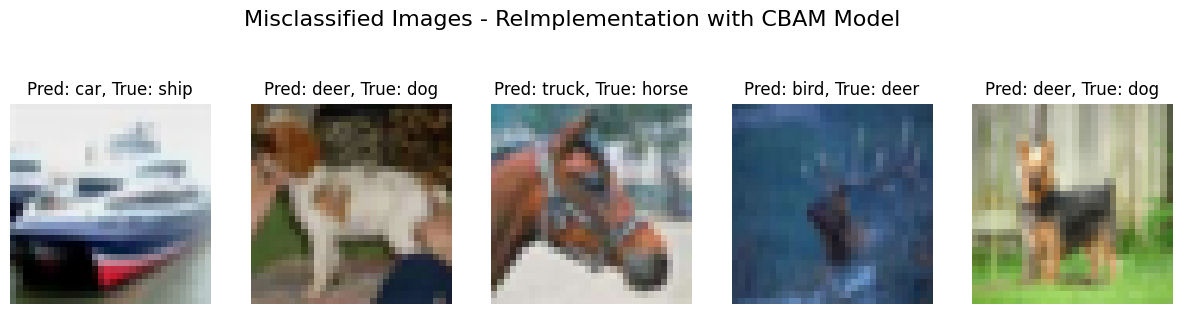

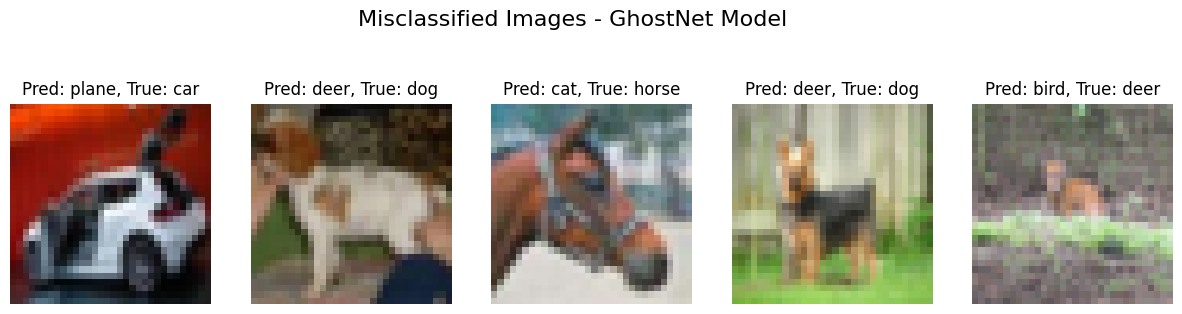

In [ ]:
#Extract 5 images from the Reimplementation and Original GhostNet Version that were incorrectly Identified:
total_images = 5
predict_reImp = output_reImp['prediction']
predict_orig = output_orig['prediction']

#Establish the classes and targets in CIFAR-10:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
targets = torch.tensor(test_dataset.targets)

#Set the predictions and targets to the CPU:
predict_reImp, predict_orig, targets = predict_reImp.to('cpu'), predict_orig.to('cpu'), targets.to('cpu')

# Find the indices where the predictions don't match the targets:
misclassified_indices_reImp = (predict_reImp != targets).nonzero(as_tuple=True)[0]
misclassified_indices_orig = (predict_orig != targets).nonzero(as_tuple=True)[0]

# Loop through the images, and grab the first five that weren't classified correctly:
fig1, ax1 = plt.subplots(1, total_images, figsize=(15,4))
fig1.suptitle("Misclassified Images - ReImplementation with CBAM Model", fontsize=16)

for i in range(min(len(misclassified_indices_reImp), total_images)):
    # Get the first three indexes of the misclassified images
    image_idx = misclassified_indices_reImp[i]

    # Unpack and get the Images from test_dataset
    image_reImp, true_label = test_dataset[image_idx]

    # Make sure image is on GPU, and permute/normalize as example does:
    image_reImp = image_reImp.detach().cpu().permute(1, 2, 0)
    image_reImp = image_reImp / 2 + 0.5

    #Print the images:
    ax1[i].imshow(image_reImp)
    ax1[i].set_title(f"Pred: {classes[predict_reImp[image_idx].item()]}, True: {classes[true_label]}")
    ax1[i].axis("off")

#Plot reImp and Orig model miscalculations:
plt.show()
print("\n" * 5)  # Adds vertical space between figures


# Repeat for the Original GhostNet Model:
fig2, ax2 = plt.subplots(1, total_images, figsize=(15,4))
fig2.suptitle("Misclassified Images - GhostNet Model", fontsize=16)

for i in range(min(len(misclassified_indices_orig), total_images)):
    # Get the first three indexes of the misclassified images
    image_idx = misclassified_indices_orig[i]

    # Unpack and get the Images from test_dataset
    image_orig, true_label = test_dataset[image_idx]

    # Make sure image is on GPU, and permute/normalize as example does:
    image_orig = image_orig.detach().cpu().permute(1, 2, 0)
    image_orig = image_orig / 2 + 0.5

    #Print the images:
    ax2[i].imshow(image_orig)
    ax2[i].set_title(f"Pred: {classes[predict_orig[image_idx].item()]}, True: {classes[true_label]}")
    ax2[i].axis("off")

#Plot reImp and Orig model miscalculations:
plt.show()

# Experiment #1:

* Testing feature maps per inferential map (s):
The purpose of this test is to see the relationship in accuracy of the # of parameters and the accuracy of the model.
I will use CIFAR-10 to test the model:

In [ ]:
#Train and test the models where the incrasing ratios:
import sys
sys.path.append('/content/drive/MyDrive/ColabNotebooks/GhostNet')
from ghostnetN3 import GhostNet_N3  # Import Reimplementation Model: ratio = 3
from ghostnetN4 import GhostNet_N4  # Import Reimplementation Model: ratio = 4
from ghostnetN5 import GhostNet_N5  # Import Reimplementation Model: ratio = 5
from ghostnetN6 import GhostNet_N6 # Import Reimplementation Model: ratio = 6
from ghostnetN7 import GhostNet_N7 # Import Reimplementation Model: ratio = 7
from ghostnetN8 import GhostNet_N8  # Import Reimplementation Model: ratio = 8
from ghostnetN12 import GhostNet_N12  # Import Reimplementation Model: ratio = 12
from ghostnetN15 import GhostNet_N15  # Import Reimplementation Model: ratio = 15

# Initialize models:
model_reImp3 = GhostNet_N3(cfgs_reImp, num_classes=10, width=1.0, dropout=0.2)
model_reImp4= GhostNet_N4(cfgs_reImp, num_classes=10, width=1.0, dropout=0.2)
model_reImp5 = GhostNet_N5(cfgs_reImp, num_classes=10, width=1.0, dropout=0.2)
model_reImp6= GhostNet_N6(cfgs_reImp, num_classes=10, width=1.0, dropout=0.2)
model_reImp7 = GhostNet_N7(cfgs_reImp, num_classes=10, width=1.0, dropout=0.2)
model_reImp8 = GhostNet_N8(cfgs_reImp, num_classes=10, width=1.0, dropout=0.2)
model_reImp12 = GhostNet_N12(cfgs_reImp, num_classes=10, width=1.0, dropout=0.2)
model_reImp15 = GhostNet_N15(cfgs_reImp, num_classes=10, width=1.0, dropout=0.2)

#Set up the training checkpoints for the models:
checkpoint_path_3 = "/content/drive/MyDrive/ColabNotebooks/GhostNet/ratio3_T1.pth"
checkpoint_path_4 = "/content/drive/MyDrive/ColabNotebooks/GhostNet/ratio4_T1.pth"
checkpoint_path_5 = "/content/drive/MyDrive/ColabNotebooks/GhostNet/ratio5_T1.pth"
checkpoint_path_6 = "/content/drive/MyDrive/ColabNotebooks/GhostNet/ratio6_T1.pth"
checkpoint_path_7 = "/content/drive/MyDrive/ColabNotebooks/GhostNet/ratio7_T1.pth"
checkpoint_path_8 = "/content/drive/MyDrive/ColabNotebooks/GhostNet/ratio8_T1.pth"
checkpoint_path_12 = "/content/drive/MyDrive/ColabNotebooks/GhostNet/ratio12_T1.pth"
checkpoint_path_15 = "/content/drive/MyDrive/ColabNotebooks/GhostNet/ratio15_T1.pth"

#Train the models for atleast 20 epoch:
criterion = nn.CrossEntropyLoss()
start = time.time()
start_epoch = 0
max_epoch = 20

#Set up the Classifier Function and optimizer:
classifier_3 = model_reImp3
classifier_4 = model_reImp4
classifier_5 = model_reImp5
classifier_6 = model_reImp6
classifier_7 = model_reImp7
classifier_8 = model_reImp8
classifier_12 = model_reImp12
classifier_15 = model_reImp15

#Move the models to the GPU:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classifier_reImp = classifier_reImp.to(device)
classifier_3, classifier_4, classifier_5 = classifier_3.to(device),classifier_4.to(device),classifier_5.to(device)
classifier_6, classifier_7 = classifier_6.to(device),classifier_7.to(device)
classifier_8, classifier_12, classifier_15 = classifier_8.to(device),classifier_12.to(device),classifier_15.to(device)

#Set the optimizers:
optimizer3 = optim.SGD(classifier_3.parameters(), lr=0.01, momentum=0.8)
optimizer4 = optim.SGD(classifier_4.parameters(), lr=0.01, momentum=0.8)
optimizer5 = optim.SGD(classifier_5.parameters(), lr=0.01, momentum=0.8)
optimizer6 = optim.SGD(classifier_6.parameters(), lr=0.01, momentum=0.8)
optimizer7 = optim.SGD(classifier_7.parameters(), lr=0.01, momentum=0.8)
optimizer8 = optim.SGD(classifier_8.parameters(), lr=0.01, momentum=0.8)
optimizer12 = optim.SGD(classifier_12.parameters(), lr=0.01, momentum=0.8)
optimizer15 = optim.SGD(classifier_15.parameters(), lr=0.01, momentum=0.8)



for epoch in range(start_epoch, max_epoch):
    print(f"\n Epoch #:{epoch+1}/{max_epoch}")

    #Call the Train Function on the reImp models:
    print("Train ratio 3 model:")
    train(classifier_3, criterion, optimizer3, train_loader, epoch, checkpoint_path_3)
    print("Train ratio 4 model:")
    train(classifier_4, criterion, optimizer4, train_loader, epoch, checkpoint_path_4)
    print("Train ratio 5 model:")
    train(classifier_5, criterion, optimizer5, train_loader, epoch, checkpoint_path_5)
    print("Train ratio 6 model:")
    train(classifier_6, criterion, optimizer6, train_loader, epoch, checkpoint_path_6)
    print("Train ratio 7 model:")
    train(classifier_7, criterion, optimizer7, train_loader, epoch, checkpoint_path_7)
    print("Train ratio 8 model:")
    train(classifier_8, criterion, optimizer8, train_loader, epoch, checkpoint_path_8)
    print("Train ratio 12 model:")
    train(classifier_12, criterion, optimizer12, train_loader, epoch, checkpoint_path_12)
    print("Train ratio 15 model:")
    train(classifier_15, criterion, optimizer15, train_loader, epoch, checkpoint_path_15)

end = time.time()
print(f'Finished Training after {end-start} s ')



 Epoch #:1/20
Train ratio 3 model:
Loading checkpoint from /content/drive/MyDrive/ColabNotebooks/GhostNet/ratio3_T1.pth...
Resuming from epoch 25


KeyboardInterrupt: 

# Test the models, and determine the FLOPs & Accuracy trend:

* The theory suggests that as the linear ratio is increased, the accuracy drops:

* The goal of this test is to analyze how it drops and where optimization could occur in linear transformation ratio use:

In [ ]:
#Test the accuracy on CIFAR-10 for the differint ratios:
epoch = 19 # 20 epochs -1
print("Results of ratio 2 model:")
output_reImp2 = test(classifier_reImp, criterion, test_loader, epoch)
print("Results of ratio 3 model:")
output_reImp3 = test(classifier_3, criterion, test_loader, epoch)
print("Results of ratio 4 model:")
output_reImp4 = test(classifier_4, criterion, test_loader, epoch)
print("Results of ratio 5 model:")
output_reImp5 = test(classifier_5, criterion, test_loader, epoch)
print("Results of ratio 6 model:")
output_reImp6 = test(classifier_6, criterion, test_loader, epoch)
print("Results of ratio 7 model:")
output_reImp7 = test(classifier_7, criterion, test_loader, epoch)
print("Results of ratio 8 model:")
output_reImp8 = test(classifier_8, criterion, test_loader, epoch)
print("Results of ratio 12 model:")
output_reImp12 = test(classifier_12, criterion, test_loader, epoch)
print("Results of ratio 15 model:")
output_reImp15 = test(classifier_15, criterion, test_loader, epoch)

Results of ratio 2 model:
Test result on epoch 20: total sample: 10000, Avg loss: 0.701, Acc: 76.390%
Results of ratio 3 model:
Test result on epoch 20: total sample: 10000, Avg loss: 0.752, Acc: 74.700%
Results of ratio 4 model:
Test result on epoch 20: total sample: 10000, Avg loss: 0.711, Acc: 75.530%
Results of ratio 5 model:
Test result on epoch 20: total sample: 10000, Avg loss: 0.730, Acc: 75.050%
Results of ratio 6 model:
Test result on epoch 20: total sample: 10000, Avg loss: 0.800, Acc: 72.420%
Results of ratio 7 model:
Test result on epoch 20: total sample: 10000, Avg loss: 0.821, Acc: 71.360%
Results of ratio 8 model:
Test result on epoch 20: total sample: 10000, Avg loss: 1.050, Acc: 62.620%
Results of ratio 12 model:
Test result on epoch 20: total sample: 10000, Avg loss: 0.889, Acc: 68.910%
Results of ratio 15 model:
Test result on epoch 20: total sample: 10000, Avg loss: 1.491, Acc: 45.120%


Plot the Relationship of Accuracy vs Transformation ratio (s):

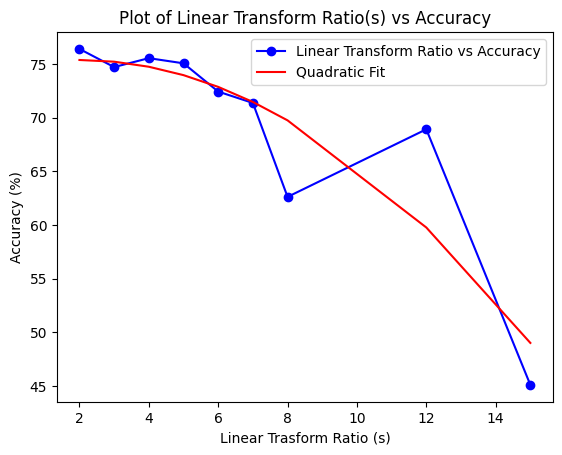

In [ ]:
#Load additional plot libraries and curve fitting tools:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

# Ratio and Accuracy data arrays:
ratio = [2, 3, 4, 5, 6, 7, 8, 12, 15]
accuracy = [76.39, 74.7, 75.53, 75.05, 72.42, 71.36, 62.62, 68.91, 45.12]

# Create a plot of ratio vs accuracy:
plt.plot(ratio, accuracy, marker='o', linestyle='-', color='b', label='Linear Transform Ratio vs Accuracy')

# Fit a poly-curve trend line:
z = np.polyfit(ratio, accuracy, 2)          # Degree 2 = quadratic curve
p = np.poly1d(z)
y_fit = p(ratio)
plt.plot(ratio, y_fit, color='red', label='Quadratic Fit')

# Add labels, title, and legend to plot: s
plt.xlabel('Linear Trasform Ratio (s)')
plt.ylabel('Accuracy (%)')
plt.title('Plot of Linear Transform Ratio(s) vs Accuracy')
plt.legend()

# Show the plot
plt.show()

Plot the relationship of FLOPs vs Transofrmation ratio (s):

In [4]:
#Install ptflops if needed:
#!pip install ptflops
from ptflops import get_model_complexity_info

# Set input shape: (channels, height, width) for CIFAR-10
input_shape = (3, 32, 32)

# Make sure models are on CPU for ptflops library:
reImp_model.eval().cpu()
model_reImp3.eval().cpu()
model_reImp4.eval().cpu()
model_reImp5.eval().cpu()
model_reImp6.eval().cpu()
model_reImp7.eval().cpu()
model_reImp8.eval().cpu()
model_reImp12.eval().cpu()
model_reImp15.eval().cpu()

# Get Flops function:
def get_flops(model):
    flops, params = get_model_complexity_info(model, input_shape, as_strings=False, print_per_layer_stat=False)
    return flops

# Get FLOPs from each model:
flops2 = get_flops(reImp_model)
flops3 = get_flops(model_reImp3)
flops4 = get_flops(model_reImp4)
flops5 = get_flops(model_reImp5)
flops6 = get_flops(model_reImp6)
flops7 = get_flops(model_reImp7)
flops8 = get_flops(model_reImp8)
flops12 = get_flops(model_reImp12)
flops15 = get_flops(model_reImp15)

# Ratios and data arrays:
ratio = [2, 3, 4, 5, 6, 7, 8, 12, 15]
flops = [flops2, flops3, flops4, flops5, flops6, flops7, flops8, flops12, flops15]

# Create a plot of ratio vs flops:
plt.plot(ratio, flops, marker='o', linestyle='-', color='r', label='Linear Transform Ratio vs FLOPs')

# Adding labels, title, and legend:
plt.xlabel('Linear Trasform Ratio (s)')
plt.ylabel('FLOPs(Million)')
plt.title('Plot of Linear Transform Ratio(s) vs FLOPs')
plt.legend()

# Show the plot
plt.show()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 115.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 66.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjit

NameError: name 'reImp_model' is not defined